In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

### Συσταδοποίηση ημερήσιων μέσων

In [2]:
kunak = pd.read_csv('kunak_filled.csv', parse_dates=[0], index_col=0).resample('D').mean()

In [3]:
pollutants = kunak[['H2S (ppb)','NO2 (ppb)', 'O3 (ppb)', 'PM2.5 (ug/m3)']]

In [4]:
scaler = MinMaxScaler()
pollutants_scaled = pollutants.copy()
pollutants_scaled[:] = scaler.fit_transform(pollutants)

In [5]:
pca = PCA(0.92)
pollutants_pca = pca.fit_transform(pollutants_scaled)
print(pca.n_components_)

3


In [6]:
n_pcs = pca.n_components_
important = [np.abs(pca.components_)[i].argmax() for i in range(n_pcs)]
names = pollutants.columns
important_features = [names[important[i]] for i in range(n_pcs)]
print(important_features)

['NO2 (ppb)', 'H2S (ppb)', 'O3 (ppb)']


In [7]:
inertias = []
for k in range(2,10):
    kmeans = KMeans(k)
    kmeans.fit(pollutants_pca)
    inertias.append(kmeans.inertia_)

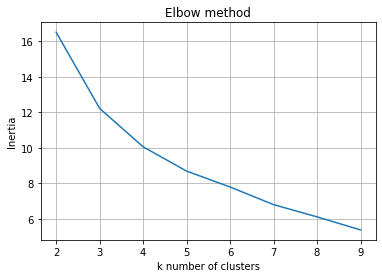

In [8]:
plt.plot(np.arange(2,10), inertias)
plt.title("Elbow method")
plt.ylabel("Inertia")
plt.xlabel("k number of clusters")
plt.xticks(np.arange(2,10))
plt.grid()
plt.savefig("Plots/kmeans/elbow.png")
plt.show()

In [9]:
kmeans = KMeans(3)
kmeans.fit(pollutants_pca)

KMeans(n_clusters=3)

In [10]:
kunak_clustered = kunak.copy()
kunak_clustered['PC1'] = pollutants_pca[:,0]
kunak_clustered['PC2'] = pollutants_pca[:,1]
kunak_clustered['PC3'] = pollutants_pca[:,2]
kunak_clustered['Cluster'] = kmeans.labels_

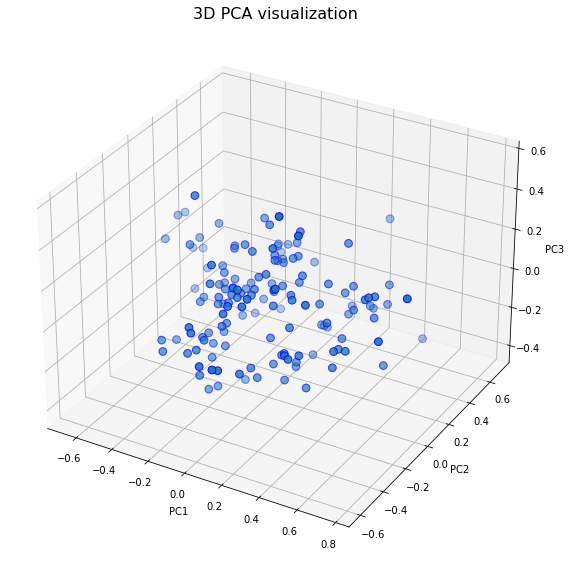

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(kunak_clustered['PC1'], kunak_clustered['PC2'], kunak_clustered['PC3'], edgecolor='b', s=60)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title("3D PCA visualization", fontsize=16)
plt.tight_layout()
plt.savefig("Plots/kmeans/pca.png")
plt.show()

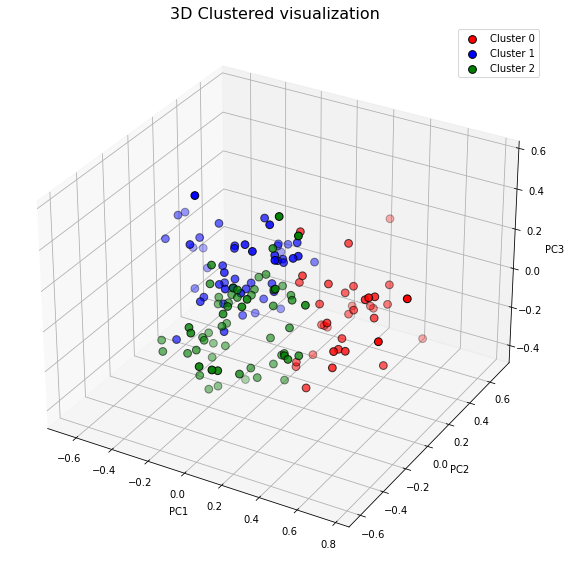

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
colors=['r','b', 'g']

for cluster in np.sort(kunak_clustered.Cluster.unique()):
    ax.scatter(kunak_clustered['PC1'][kunak_clustered.Cluster==cluster], 
               kunak_clustered['PC2'][kunak_clustered.Cluster==cluster], 
               kunak_clustered['PC3'][kunak_clustered.Cluster==cluster], 
               edgecolor='black', c=colors[cluster], s=60, label=f'Cluster {cluster}')
    ax.legend()

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("3D Clustered visualization", fontsize=16)
plt.tight_layout()
plt.savefig("Plots/kmeans/clusters.png")
plt.show()

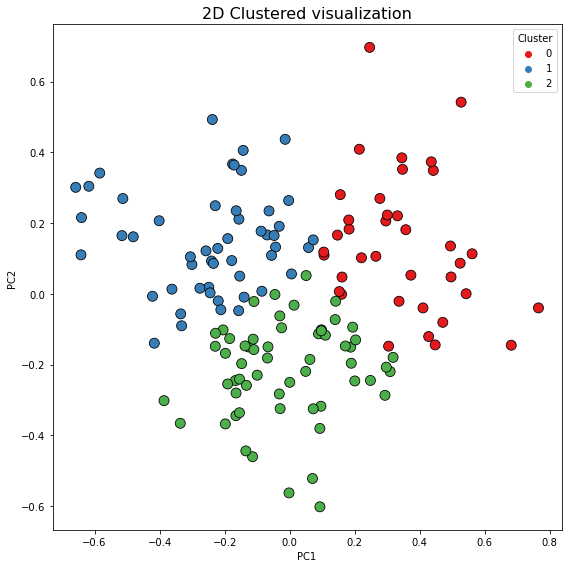

In [20]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=kunak_clustered['PC1'], y=kunak_clustered['PC2'], hue=kunak_clustered['Cluster'], edgecolor='black', s=100, palette='Set1')
plt.title("2D Clustered visualization", fontsize=16)
plt.tight_layout()
plt.savefig("Plots/kmeans/2dclusters.png")
plt.show()

In [13]:
profiles = round(kunak_clustered.drop(columns=['PC1','PC2','PC3','Dew Point (C)','Temp (C)','Humidity (%)','PM1 (ug/m3)','PM10 (ug/m3)',]),0)
profiles

,H2S (ppb),NO2 (ppb),O3 (ppb),PM2.5 (ug/m3),Cluster
Datetime,,,,,
2022-04-10,7.0,53.0,24.0,5.0,1
2022-04-11,1.0,36.0,48.0,5.0,0
2022-04-12,6.0,34.0,37.0,4.0,0
2022-04-13,4.0,54.0,28.0,5.0,1
2022-04-14,7.0,60.0,24.0,9.0,1
...,...,...,...,...,...
2022-08-31,14.0,44.0,42.0,11.0,2
2022-09-01,14.0,56.0,38.0,14.0,2
2022-09-02,9.0,74.0,31.0,11.0,1


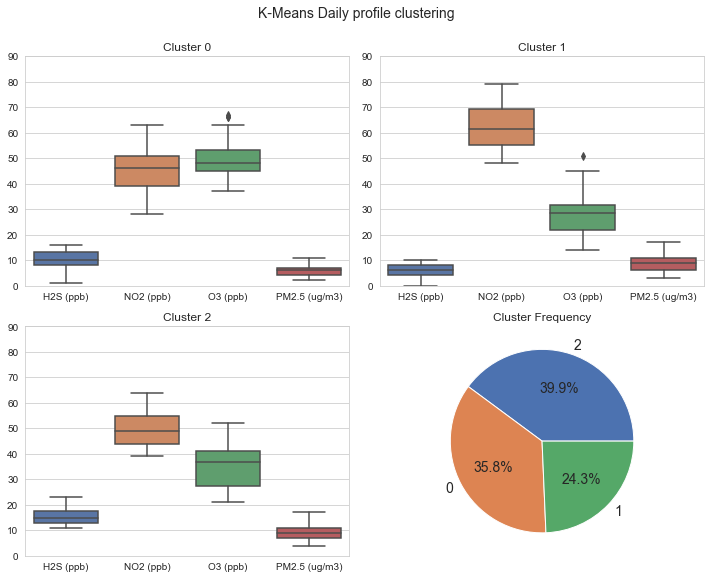

In [38]:
sns.set_style('whitegrid')
sns.set_palette("deep")
fig, ax = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(data=profiles.loc[profiles['Cluster']==0].drop(columns='Cluster'), ax=ax[0,0])
sns.boxplot(data=profiles.loc[profiles['Cluster']==1].drop(columns='Cluster'), ax=ax[0,1])
sns.boxplot(data=profiles.loc[profiles['Cluster']==2].drop(columns='Cluster'), ax=ax[1,0])
profiles['Cluster'].value_counts().plot(kind='pie',autopct='%1.1f%%', fontsize=14, ax=ax[1,1])


ax[0,0].set_title('Cluster 0')
ax[0,1].set_title('Cluster 1')
ax[1,0].set_title('Cluster 2')
ax[1,1].set_title('Cluster Frequency')
ax[1,1].set_ylabel("")
ax[0,0].set_ylim((0,90))
ax[0,1].set_ylim((0,90))
ax[1,0].set_ylim((0,90))

plt.suptitle("K-Means Daily profile clustering", fontsize=14, y=1)
plt.tight_layout()
plt.savefig("Plots/kmeans/profiles.png")
plt.show()